In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split,KFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB,BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.base import BaseEstimator, ClassifierMixin
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import pickle


# 1. Explore the Data

In [3]:
# Load the CSV file uploaded by the user
csv_file_path = '/home/aimssn-it/Desktop/Databeez/german_credit_data.csv'

# Read the CSV file
data = pd.read_csv(csv_file_path)

# Display the first few rows and basic information about the dataset
data_info = {
    "head": data.head(),
    "info": data.info(),
    "description": data.describe(include='all')
}

data_info


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
 10  Risk              1000 non-null   object
dtypes: int64(5), object(6)
memory usage: 86.1+ KB


{'head':    Unnamed: 0  Age     Sex  Job Housing Saving accounts Checking account  \
 0           0   67    male    2     own             NaN           little   
 1           1   22  female    2     own          little         moderate   
 2           2   49    male    1     own          little              NaN   
 3           3   45    male    2    free          little           little   
 4           4   53    male    2    free          little           little   
 
    Credit amount  Duration              Purpose  Risk  
 0           1169         6             radio/TV  good  
 1           5951        48             radio/TV   bad  
 2           2096        12            education  good  
 3           7882        42  furniture/equipment  good  
 4           4870        24                  car   bad  ,
 'info': None,
 'description':          Unnamed: 0          Age   Sex          Job Housing Saving accounts  \
 count   1000.000000  1000.000000  1000  1000.000000    1000             81

In [4]:
# Data types of each column
data_types = data.dtypes

# Count of missing values in each column
missing_values = data.isnull().sum()

# Summary statistics
summary_statistics = data.describe(include='all')

data_analysis = {
    "data_types": data_types,
    "missing_values": missing_values,
    "summary_statistics": summary_statistics
}

data_analysis

{'data_types': Unnamed: 0           int64
 Age                  int64
 Sex                 object
 Job                  int64
 Housing             object
 Saving accounts     object
 Checking account    object
 Credit amount        int64
 Duration             int64
 Purpose             object
 Risk                object
 dtype: object,
 'missing_values': Unnamed: 0            0
 Age                   0
 Sex                   0
 Job                   0
 Housing               0
 Saving accounts     183
 Checking account    394
 Credit amount         0
 Duration              0
 Purpose               0
 Risk                  0
 dtype: int64,
 'summary_statistics':          Unnamed: 0          Age   Sex          Job Housing Saving accounts  \
 count   1000.000000  1000.000000  1000  1000.000000    1000             817   
 unique          NaN          NaN     2          NaN       3               4   
 top             NaN          NaN  male          NaN     own          little   
 freq       

In [5]:
data.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


# Preprocessing

In [6]:

# Handle missing values
data = data.assign(**{
    'Saving accounts': data['Saving accounts'].fillna('unknown'),
    'Checking account': data['Checking account'].fillna('unknown')
})

# Encode categorical variables
data_encoded = data.copy()
data_encoded=data_encoded.drop(['Unnamed: 0'], axis=1)
data_encoded['Sex'] = data_encoded['Sex'].map({'male': 0, 'female': 1})
data_encoded['Housing'] = data_encoded['Housing'].map({'own': 0, 'rent': 1, 'free': 2})
data_encoded['Saving accounts'] = data_encoded['Saving accounts'].astype('category').cat.codes
data_encoded['Checking account'] = data_encoded['Checking account'].astype('category').cat.codes
data_encoded['Purpose'] = data_encoded['Purpose'].astype('category').cat.codes
data_encoded['Risk'] = data_encoded['Risk'].map({'good': 1, 'bad': 0})

# Normalize or scale numerical features
scaler = StandardScaler()
numerical_features = ['Age', 'Job', 'Credit amount', 'Duration']
data_encoded[numerical_features] = scaler.fit_transform(data_encoded[numerical_features])



In [7]:
data_encoded.columns

Index(['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account',
       'Credit amount', 'Duration', 'Purpose', 'Risk'],
      dtype='object')

In [8]:
data_encoded.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,2.766456,0,0.146949,0,4,0,-0.745131,-1.236478,5,1
1,-1.191404,1,0.146949,0,0,1,0.949817,2.248194,5,0
2,1.183312,0,-1.383771,0,0,3,-0.416562,-0.738668,3,1
3,0.831502,0,0.146949,2,0,0,1.634247,1.750384,4,1
4,1.535122,0,0.146949,2,0,0,0.566664,0.256953,1,0


                       Age       Sex       Job   Housing  Saving accounts  \
Age               1.000000 -0.161694  0.015673  0.112051         0.084245   
Sex              -0.161694  1.000000 -0.070298  0.033818        -0.034982   
Job               0.015673 -0.070298  1.000000  0.101939         0.011709   
Housing           0.112051  0.033818  0.101939  1.000000        -0.003262   
Saving accounts   0.084245 -0.034982  0.011709 -0.003262         1.000000   
Checking account  0.059751 -0.025578  0.040663 -0.121380         0.222867   
Credit amount     0.032716 -0.093482  0.285385  0.171585         0.064630   
Duration         -0.036136 -0.081432  0.210910  0.137434         0.047661   
Purpose          -0.074084  0.063231 -0.025326 -0.086839        -0.053225   
Risk              0.091127 -0.075493 -0.032735 -0.127789         0.178943   

                  Checking account  Credit amount  Duration   Purpose  \
Age                       0.059751       0.032716 -0.036136 -0.074084   
Sex   

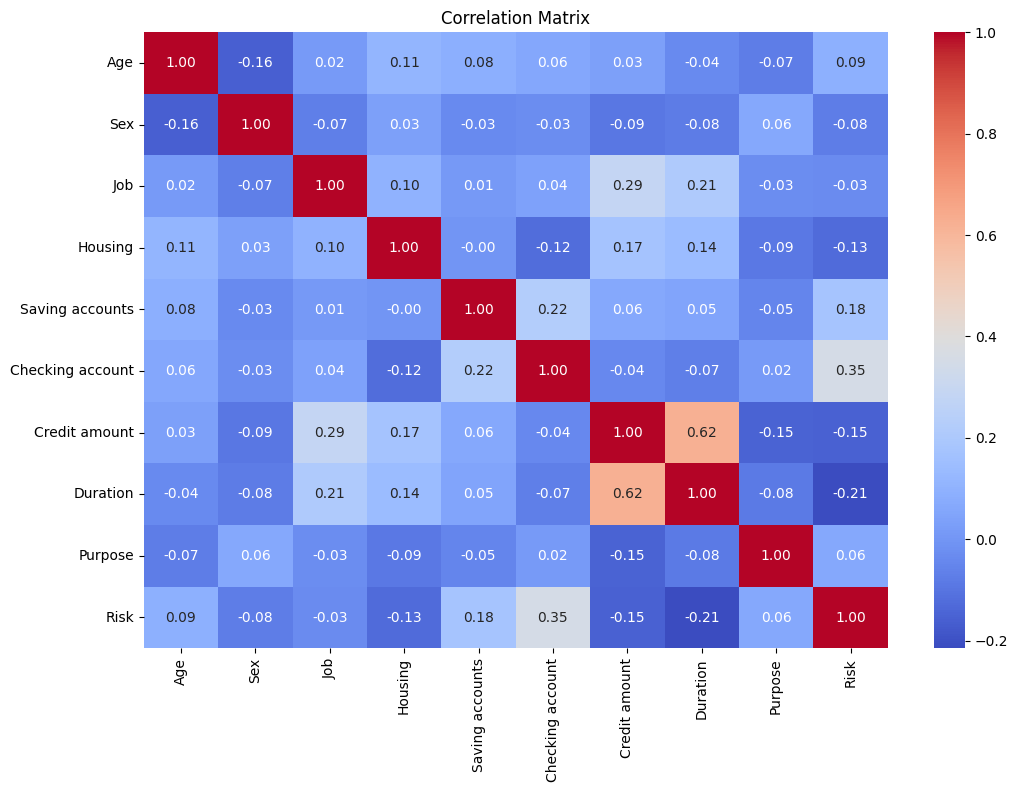

Correlation with target variable 'Risk':
Risk                1.000000
Checking account    0.350847
Saving accounts     0.178943
Age                 0.091127
Purpose             0.061145
Job                -0.032735
Sex                -0.075493
Housing            -0.127789
Credit amount      -0.154739
Duration           -0.214927
Name: Risk, dtype: float64


In [9]:

# Create correlation matrix
correlation_matrix = data_encoded.corr()

# Display the correlation matrix
print(correlation_matrix)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Check correlation with the target variable 'Risk'
correlation_with_target = correlation_matrix['Risk'].sort_values(ascending=False)
print("Correlation with target variable 'Risk':")
print(correlation_with_target)

Identify key variables influencing credit scoring using correlation matrices and visualizations (e.g., heatmaps, pair plots).

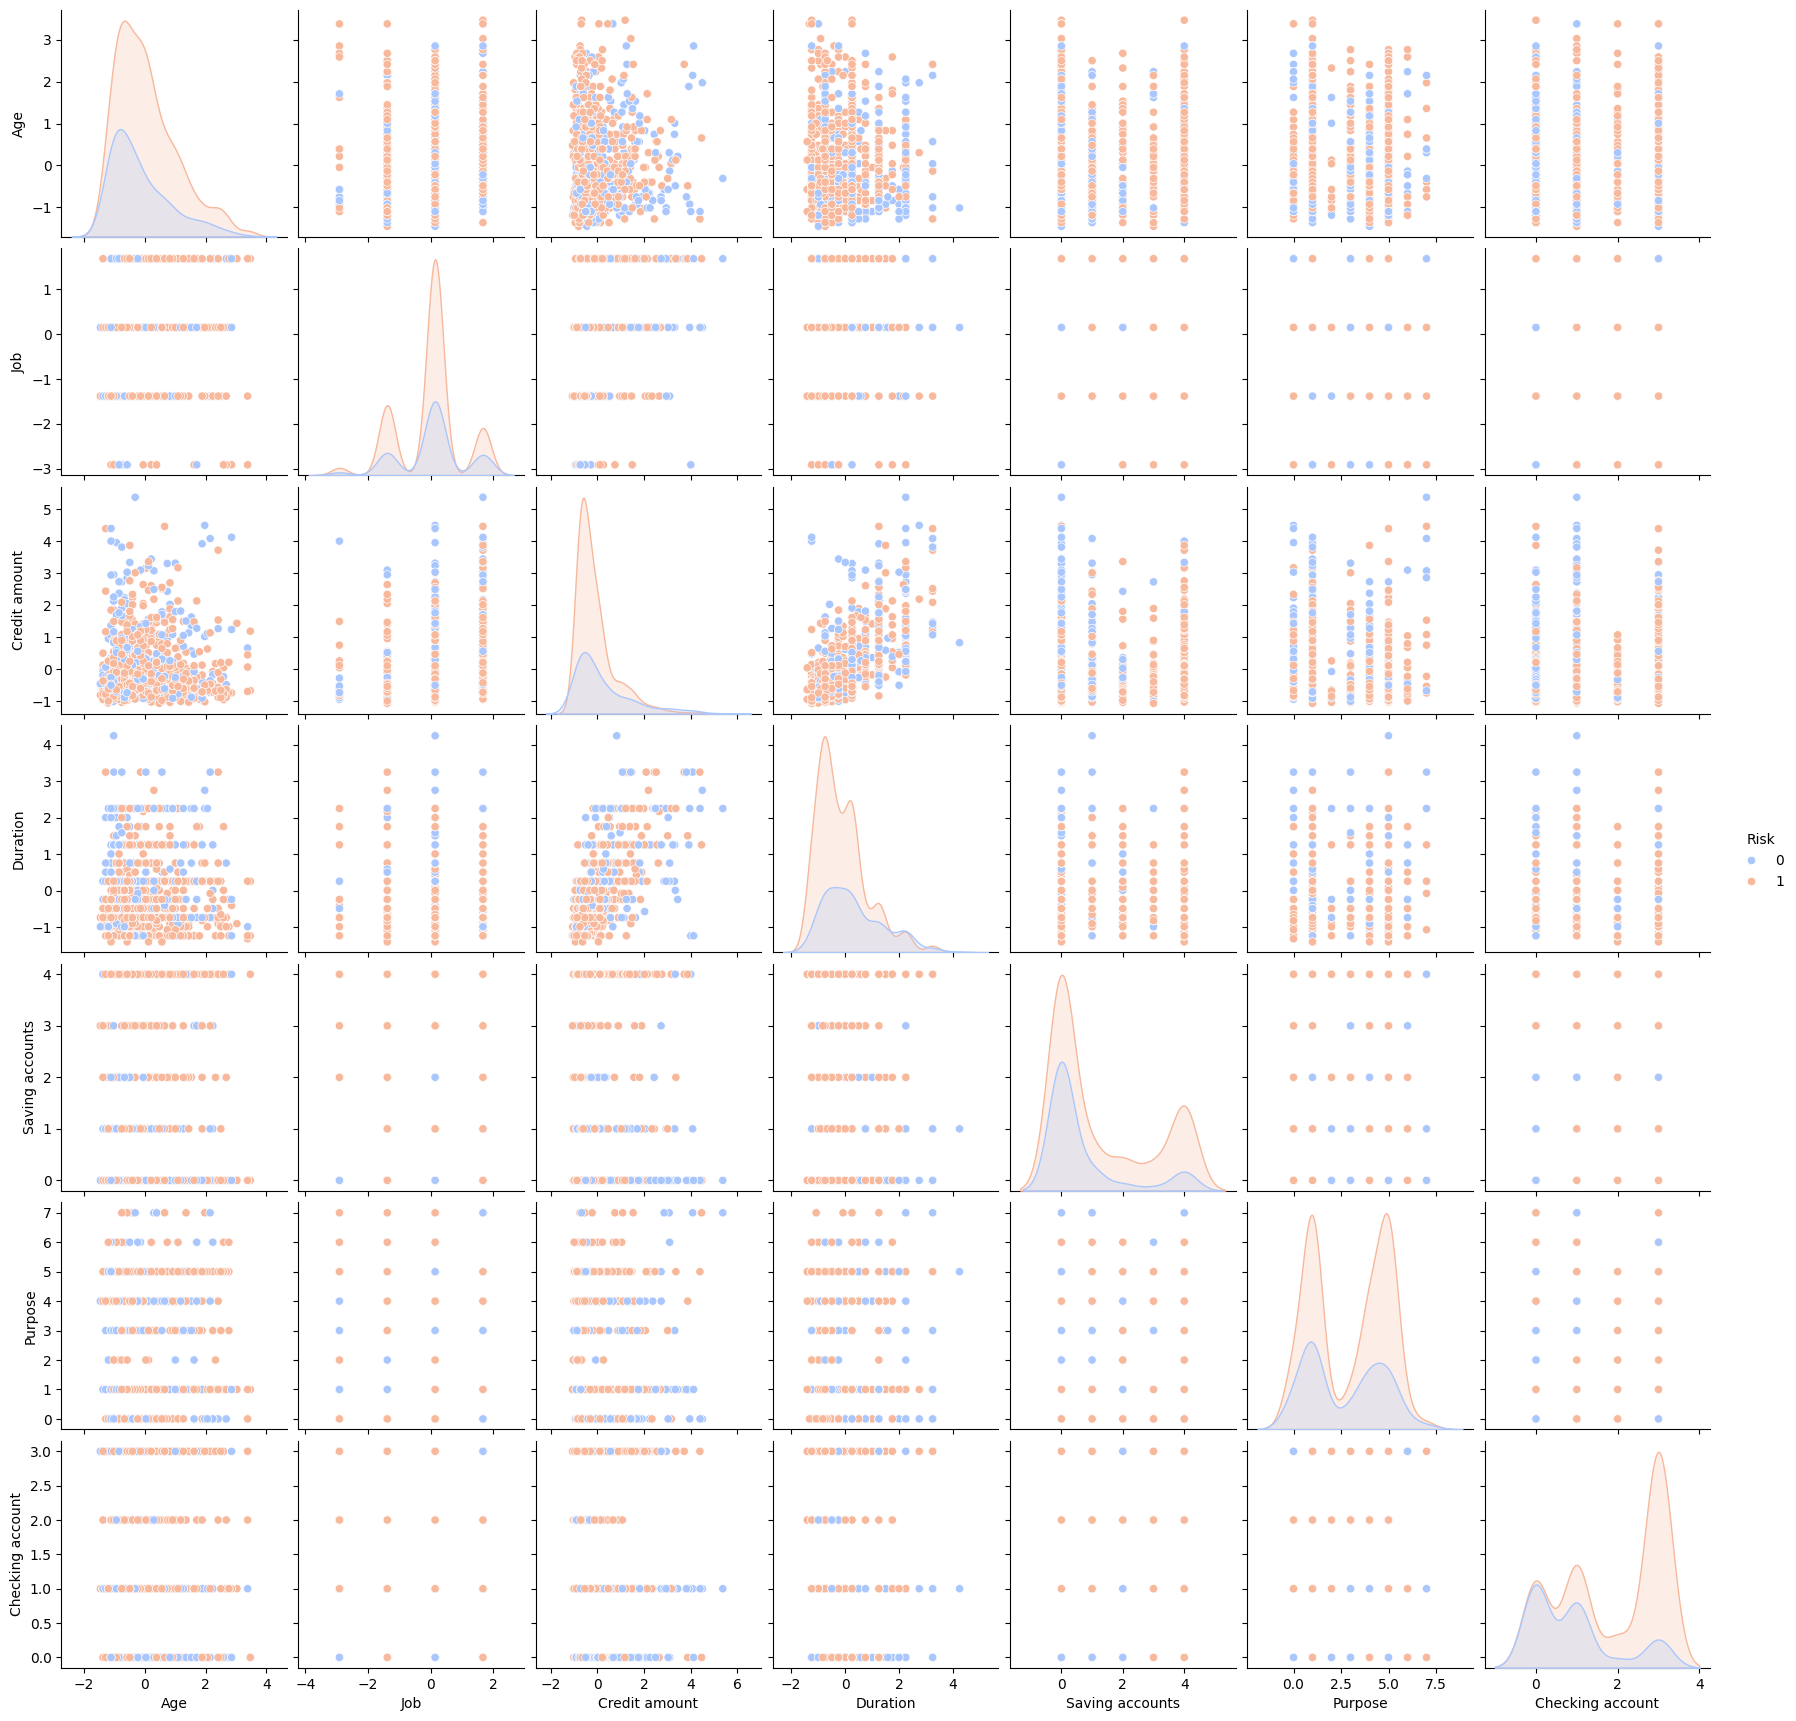

In [10]:

# Pair plot for selected features
selected_features = ['Age', 'Job', 'Credit amount', 'Duration', 'Saving accounts','Purpose','Checking account','Risk']
sns.pairplot(data_encoded[selected_features], hue='Risk', palette='coolwarm')
plt.show()

In [11]:
# Split the dataset into training and testing sets
X = data_encoded.drop('Risk', axis=1)
y = data_encoded['Risk']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Modelling

In [12]:

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(eval_metric='logloss'),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Support Vector Machine": SVC(probability=True),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Gaussian Naive Bayes": GaussianNB(),
    "Bernoulli Naive Bayes": BernoulliNB(),
    "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
    "Quadratic Discriminant Analysis": QuadraticDiscriminantAnalysis(),
    "Extra Trees": ExtraTreesClassifier(),

}

# Train and evaluate models
best_model = None
best_score = 0
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred)
    
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print("\n")
    
    if auc_roc > best_score:
        best_score = auc_roc
        best_model = model

# Save the best-performing model using pickle
with open('best_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

print(f"Best model saved: {best_model}")

Model: Logistic Regression
Accuracy: 0.7450
Precision: 0.7711
Recall: 0.9078
F1-score: 0.8339
AUC-ROC: 0.6319
[[ 21  38]
 [ 13 128]]
              precision    recall  f1-score   support

           0       0.62      0.36      0.45        59
           1       0.77      0.91      0.83       141

    accuracy                           0.74       200
   macro avg       0.69      0.63      0.64       200
weighted avg       0.73      0.74      0.72       200



Model: Random Forest
Accuracy: 0.7300
Precision: 0.7702
Recall: 0.8794
F1-score: 0.8212
AUC-ROC: 0.6262
[[ 22  37]
 [ 17 124]]
              precision    recall  f1-score   support

           0       0.56      0.37      0.45        59
           1       0.77      0.88      0.82       141

    accuracy                           0.73       200
   macro avg       0.67      0.63      0.64       200
weighted avg       0.71      0.73      0.71       200



Model: XGBoost
Accuracy: 0.7800
Precision: 0.8089
Recall: 0.9007
F1-score: 0.8523


## Model optimizations

In [ ]:

# Define the XGBClassifier wrapper for sklearn compatibility
class XGBClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, **kwargs):
        # Define the parameters explicitly in the constructor
        self.model = XGBClassifier(  **kwargs)

        
    def fit(self, X, y):
        # Fit the XGBClassifier model
        self.model.fit(X, y)
        return self

    def predict(self, X):
        # Predict using the fitted model
        return self.model.predict(X)

    def predict_proba(self, X):
        # Predict probabilities using the fitted model
        return self.model.predict_proba(X)

    def score(self, X, y):
        # Return the accuracy score using the model
        return self.model.score(X, y)

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifierWrapper(eval_metric='logloss'),  # Using the wrapped XGBClassifier
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Support Vector Machine": SVC(probability=True),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Gaussian Naive Bayes": GaussianNB(),
    "Bernoulli Naive Bayes": BernoulliNB(),
    "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
    "Quadratic Discriminant Analysis": QuadraticDiscriminantAnalysis(),
    "Extra Trees": ExtraTreesClassifier(),
}

# Train and evaluate models
best_model = None
best_score = 0
for name, model in models.items():
    kfold = KFold(n_splits=10, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')
    print(f"{name}: {cv_results.mean():.4f} ({cv_results.std():.4f})")
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred)
    
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print("\n")
    
    if auc_roc > best_score:
        best_score = auc_roc
        best_model = model

# Save the best-performing model using pickle
with open('best_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

print(f"Best model saved: {best_model}")


Logistic Regression: 0.7567 (0.0432)
Model: Logistic Regression
Accuracy: 0.7350
Precision: 0.7619
Recall: 0.9078
F1-score: 0.8285
AUC-ROC: 0.6149
[[ 19  40]
 [ 13 128]]
              precision    recall  f1-score   support

           0       0.59      0.32      0.42        59
           1       0.76      0.91      0.83       141

    accuracy                           0.73       200
   macro avg       0.68      0.61      0.62       200
weighted avg       0.71      0.73      0.71       200



Random Forest: 0.7411 (0.0397)
Model: Random Forest
Accuracy: 0.7500
Precision: 0.7791
Recall: 0.9007
F1-score: 0.8355
AUC-ROC: 0.6453
[[ 23  36]
 [ 14 127]]
              precision    recall  f1-score   support

           0       0.62      0.39      0.48        59
           1       0.78      0.90      0.84       141

    accuracy                           0.75       200
   macro avg       0.70      0.65      0.66       200
weighted avg       0.73      0.75      0.73       200



XGBoost: nan (